# **Data Analysis**

# **0. Set Up**

Before diving in the models, let's reload the notebook to keep it updated.

In [1]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('seaborn-darkgrid')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Then, let's load the dependencies:

In [2]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torchtext import datasets

from torch.nn.utils.rnn import pad_packed_sequence, PackedSequence
from torch.utils.data import DataLoader

# Data science
import spacy
import numpy as np
import time
import random

In [3]:
#Let's not forget to fix the seed for random generated numbers !
SEED = 2020 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Baseline**


# 1. Dataset

### 1.1. NoReC fine

In [4]:
from torchtext.datasets import SequenceTaggingDataset


class NoReCfine(SequenceTaggingDataset):
    def __init__(self, path, fields, encoding="utf-8", separator="\t", **kwargs):
        super().__init__(path, fields)

    @classmethod
    def splits(cls, fields, train_data="data/train.conll", dev_data="data/dev.conll", test_data="data/test.conll"):
        return NoReCfine(train_data, fields), NoReCfine(dev_data, fields), NoReCfine(test_data, fields)

In [5]:
import torchtext

TEXT = torchtext.data.Field(lower=False, include_lengths=True, batch_first=True)
LABEL = torchtext.data.Field(batch_first=True, unk_token=None)
FIELDS = [("text", TEXT), ("label", LABEL)]

train_data, eval_data, test_data = NoReCfine.splits(FIELDS)

In [6]:
print(f'Number of training examples: {len(train_data):,}')
print(f'Number of training examples: {len(eval_data):,}')
print(f'Number of testing examples:    {len(test_data)}')

text_length = [len(sentence) for sentence in list(train_data.text)]

print(f"\nNumber of sentences in train_data.text: {len(text_length)}")
print(f'Number of words in train_data: {sum(text_length):,}')

Number of training examples: 5,915
Number of training examples: 1,151
Number of testing examples:    895

Number of sentences in train_data.text: 5915
Number of words in train_data: 98,483


In [7]:
print("What's inside the training data:")
print(vars(train_data[0]))

What's inside the training data:
{'text': ['Lite', 'tight', 'Tempah'], 'label': ['O', 'O', 'B-targ-Negative']}


### 1.2. Vocabulary

In [8]:
from torchtext.vocab import Vectors

VOCAB_SIZE = 1_200_000
VECTORS = Vectors(name='model.txt')

# Create the vocabulary for words embeddings
TEXT.build_vocab(train_data, 
                 max_size = VOCAB_SIZE, 
                 vectors = VECTORS, 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

### 1.2. Data Analysis

In [9]:
VECTORS.vectors.shape

torch.Size([1182371, 100])

In [10]:
TEXT.vocab.vectors.shape

torch.Size([19192, 100])

In [11]:
print("Vocabulary defined on the training data, with the help of pre-trained embeddings:\n")

print(TEXT.vocab.itos[0:20])

Vocabulary defined on the training data, with the help of pre-trained embeddings:

['<unk>', '<pad>', '.', ',', 'og', 'er', 'i', 'som', 'en', 'det', 'på', 'å', 'av', 'med', 'til', 'for', '«', '»', 'har', 'den']


In [12]:
print(f"The word '{TEXT.vocab.itos[8867]}' is not part of the pre-trained embeddings.\n")

print(f"PyTorch sets its vector to zero:\n{TEXT.vocab.vectors[8867]}")

The word 'Martel' is not part of the pre-trained embeddings.

PyTorch sets its vector to zero:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [13]:
print("Vocabulary informations:\n")
print(f"Labels vocabulary:\n{LABEL.vocab.itos}\n")
print(f"Text vocabulary:\n{TEXT.vocab.itos[:10]}\n")
print(f"Most frequent words:\n{TEXT.vocab.freqs.most_common(10)}")

Vocabulary informations:

Labels vocabulary:
['<pad>', 'O', 'I-targ-Positive', 'B-targ-Positive', 'I-targ-Negative', 'B-targ-Negative']

Text vocabulary:
['<unk>', '<pad>', '.', ',', 'og', 'er', 'i', 'som', 'en', 'det']

Most frequent words:
[('.', 4585), (',', 4085), ('og', 2878), ('er', 2326), ('i', 2071), ('som', 1699), ('en', 1628), ('på', 1318), ('det', 1318), ('å', 1222)]


# Visualization

In [14]:
[len(train_data), len(eval_data), len(test_data)]

[5915, 1151, 895]

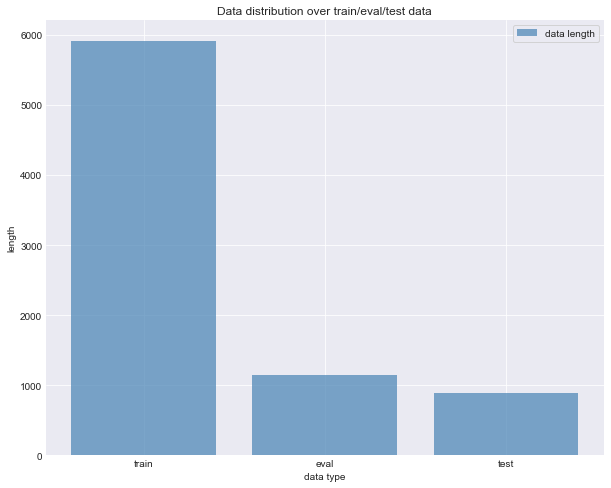

In [15]:
plt.bar([0, 1, 2], [len(train_data), len(eval_data), len(test_data)], color="steelblue", alpha=0.7)
plt.xticks([0, 1, 2], ["train", "eval", "test"])
plt.title("Data distribution over train/eval/test data")
plt.legend(["data length"], frameon=True)
plt.ylabel("length")
plt.xlabel("data type")
plt.show()

In [16]:
LABEL.vocab.itos

['<pad>',
 'O',
 'I-targ-Positive',
 'B-targ-Positive',
 'I-targ-Negative',
 'B-targ-Negative']

In [17]:
import pandas as pd

train_text = [word for text in train_data.text for word in text]
eval_text  = [word for text in eval_data.text for word in text]
test_text  = [word for text in test_data.text for word in text]

train_label = [label for labels in train_data.label for label in labels]
eval_label  = [label for labels in eval_data.label for label in labels]
test_label  = [label for labels in test_data.label for label in labels]

train_label_sum = {label: 0 for label in LABEL.vocab.itos[1:]}
eval_label_sum  = {label: 0 for label in LABEL.vocab.itos[1:]}
test_label_sum  = {label: 0 for label in LABEL.vocab.itos[1:]}

for label in train_label:
    train_label_sum[label] += 1
for label in eval_label:
    eval_label_sum[label] += 1
for label in test_label:
    test_label_sum[label] += 1
    
df_label = pd.DataFrame({'train': train_label_sum, 'eval': eval_label_sum, 'test': test_label_sum})
df_label.head()

,train,eval,test
O,91691,18336,14425
I-targ-Positive,2339,436,348
B-targ-Positive,2245,433,366
I-targ-Negative,1114,207,117
B-targ-Negative,1094,196,145


In [18]:
df_label.transpose().mean(), df_label.transpose().mean().sum()

(O                  41484.000000
 I-targ-Positive     1041.000000
 B-targ-Positive     1014.666667
 I-targ-Negative      479.333333
 B-targ-Negative      478.333333
 dtype: float64,
 44497.333333333336)

In [19]:
weights = (df_label.transpose().mean().sum() - df_label.transpose().mean().values) / df_label.transpose().mean().sum()

weights

array([0.06771941, 0.97660534, 0.97719714, 0.98922782, 0.98925029])

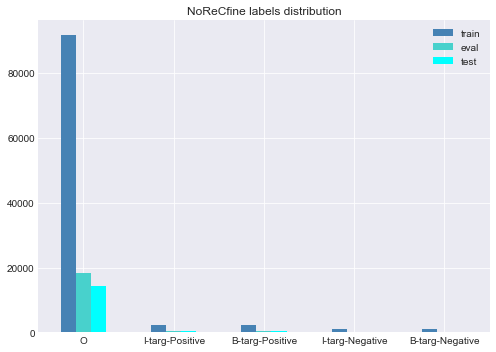

In [20]:
ax = df_label.plot.bar(rot=0, color=['steelblue', 'mediumturquoise', 'aqua'], figsize=(7, 5))
plt.title("NoReCfine labels distribution")
plt.tight_layout()

plt.savefig('img/norecfine_distribution.png', dpi=200)

### 1.3.2. Global data content

Okay, so each labels are "equally" represented in each data. But what comes to words ?

In [20]:
print("4 first texts in one big string:")
print(' '.join([' '.join(text) for text in list(train_data.text)[:4]]))

4 first texts in one big string:
Lite tight Tempah Festivalens hittil lengste time er over . Tinie Tempah skuffer . Londonrapper Tinie Tempah utnytter ikke eget potensiale når han onsdag kveld fyller Amfiscenen på Hovefestivalen .


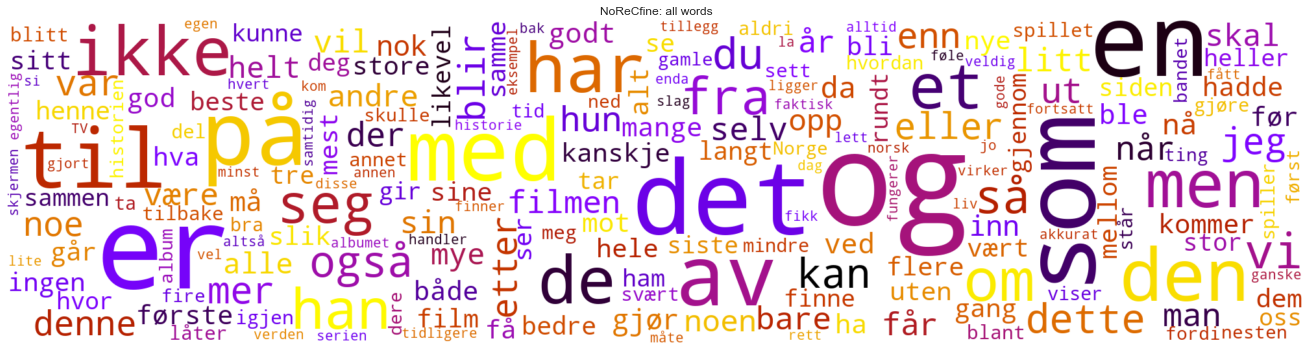

In [21]:
from wordcloud import WordCloud

# Converting all list of words from train_data to one big string document
all_words = ' '.join(train_text)

# Create a cloud of words
word_cloud = WordCloud(collocations=False, width=2000, height=500, random_state=21, max_font_size=200, background_color="white", colormap="gnuplot").generate(all_words)

# Plot it !
plt.subplots(figsize=(20, 5))
plt.imshow(word_cloud, interpolation="bilinear")
plt.title("NoReCfine: all words")
plt.axis('off')
plt.tight_layout()

plt.savefig('img/norecfine_allwords.png', dpi=200)

Let's look at the stats more closely:

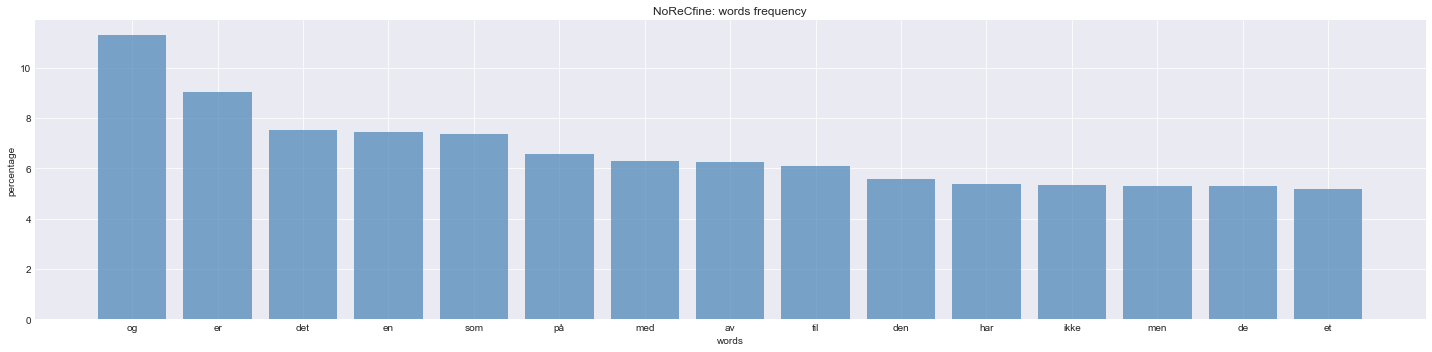

In [36]:
from scipy.special import softmax

# Frequencies
all_words_dict = word_cloud.words_
all_words_freq = softmax(list(all_words_dict.values())[:15]) * 100
all_words_name = list(all_words_dict.keys())[:15]

# Plot it !
plt.subplots(figsize=(20, 5))
plt.title("NoReCfine: words frequency")
plt.bar(range(len(all_words_freq)), all_words_freq, align='center', color="steelblue", alpha=0.7)
plt.xticks(range(len(all_words_freq)), all_words_name)
plt.ylabel("percentage")
plt.xlabel("words")

plt.tight_layout()
plt.savefig('img/norecfine_allwords_frequency.png', dpi=200)

### 1.3.3. Per classdata content

Are words in positive sentences as frequents as in negative ones ?

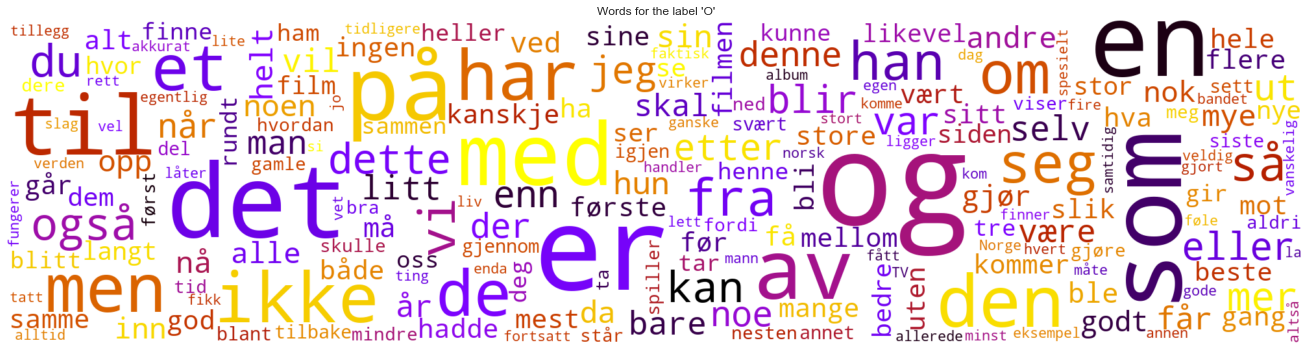

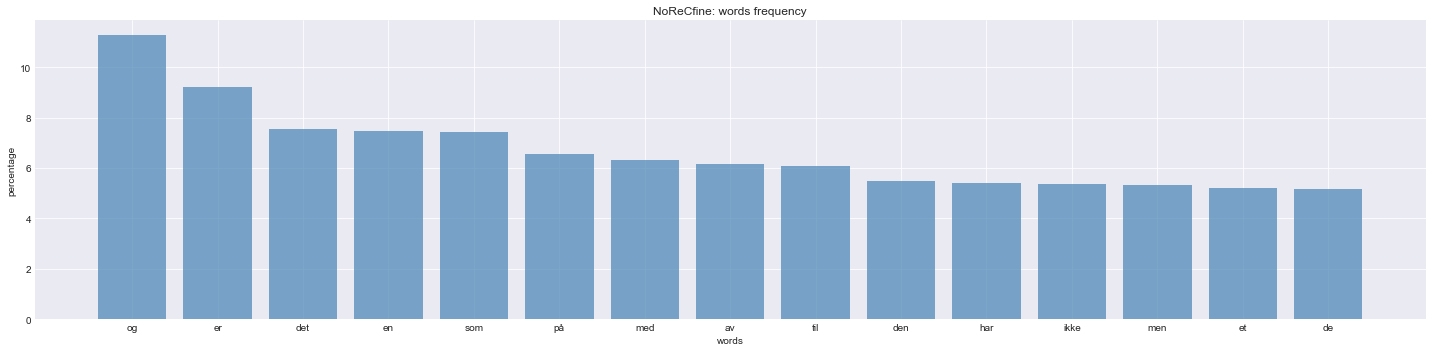

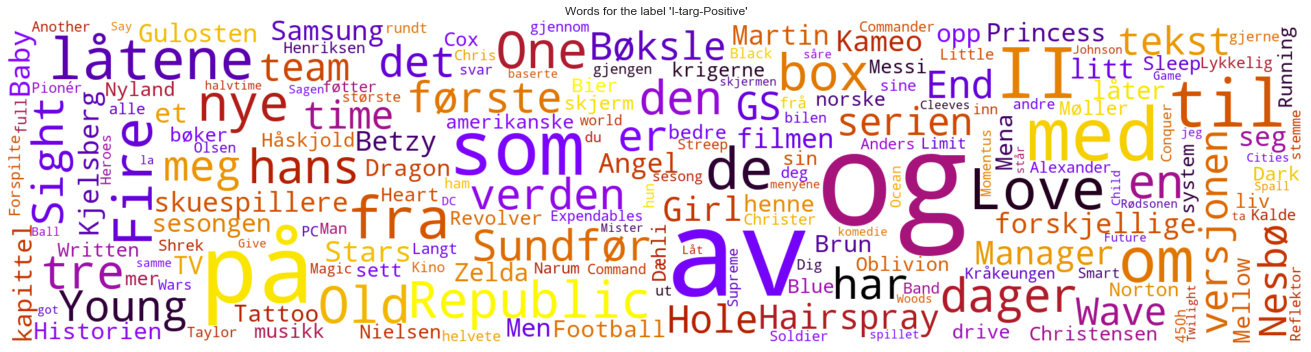

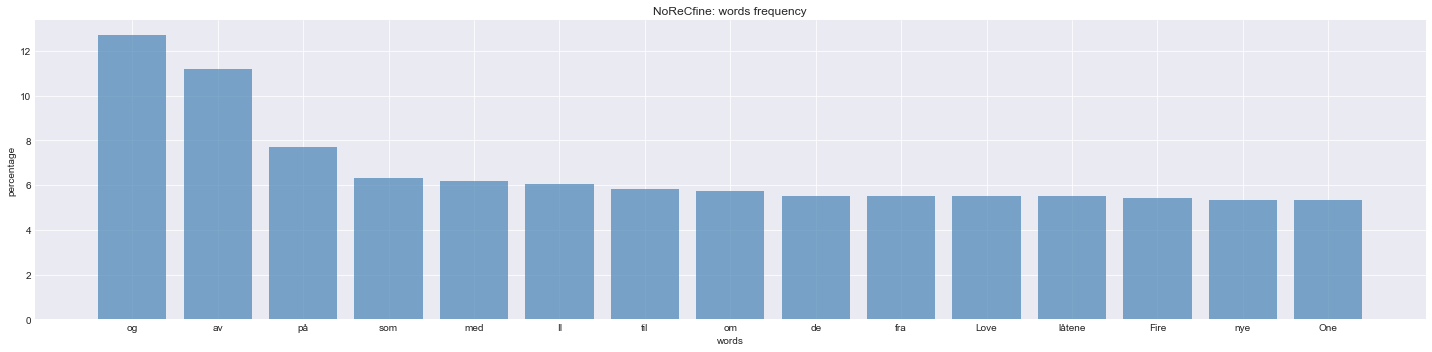

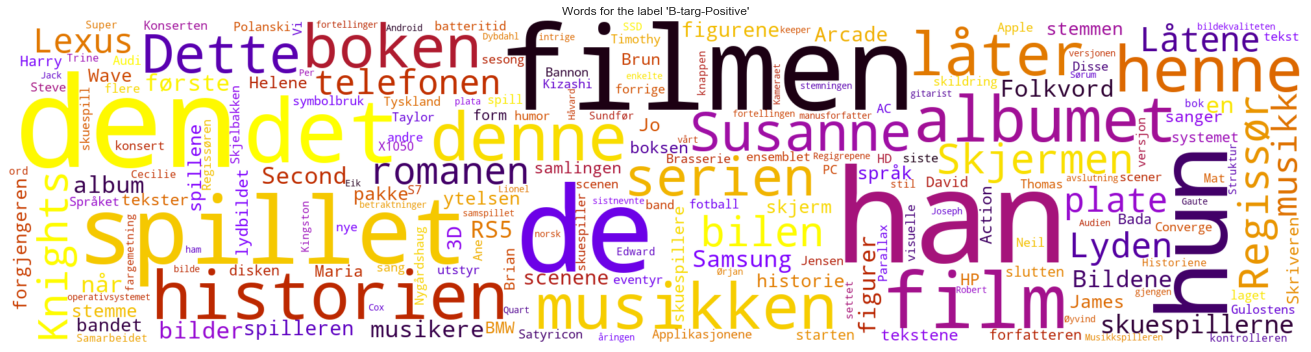

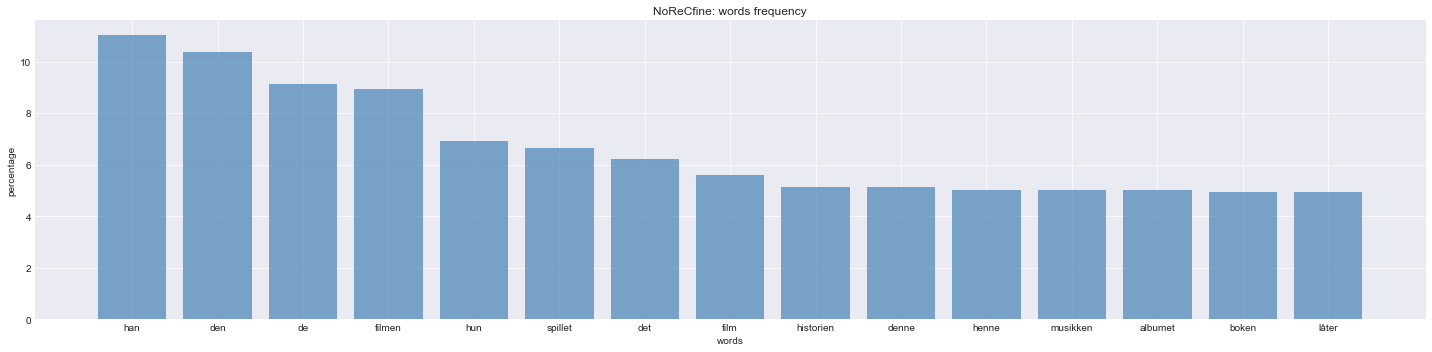

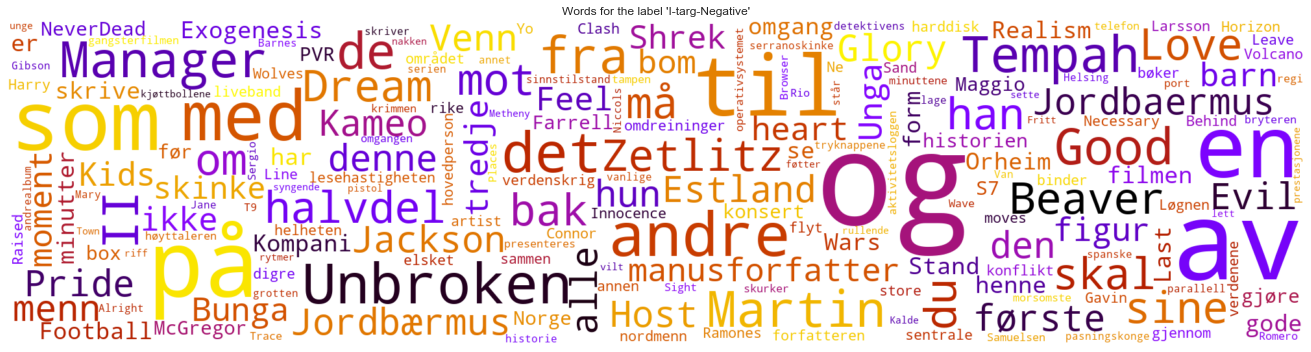

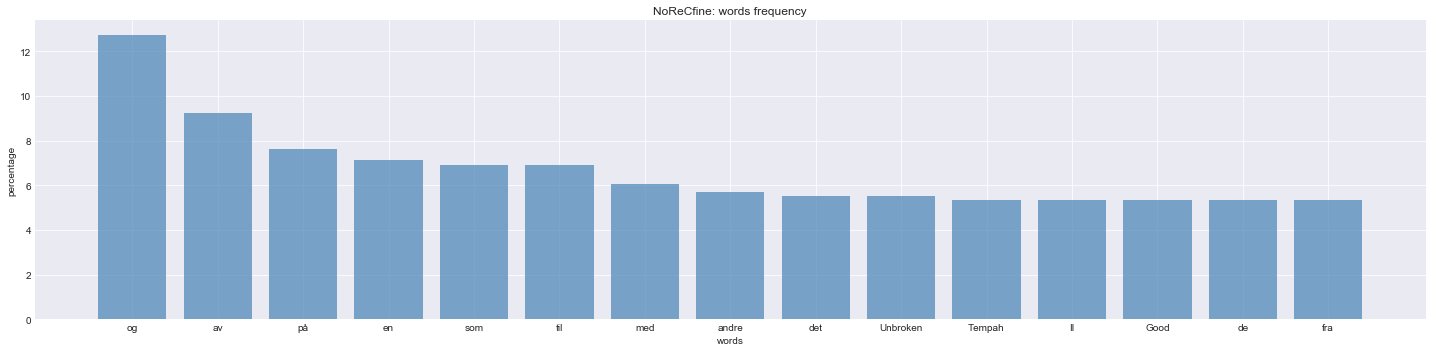

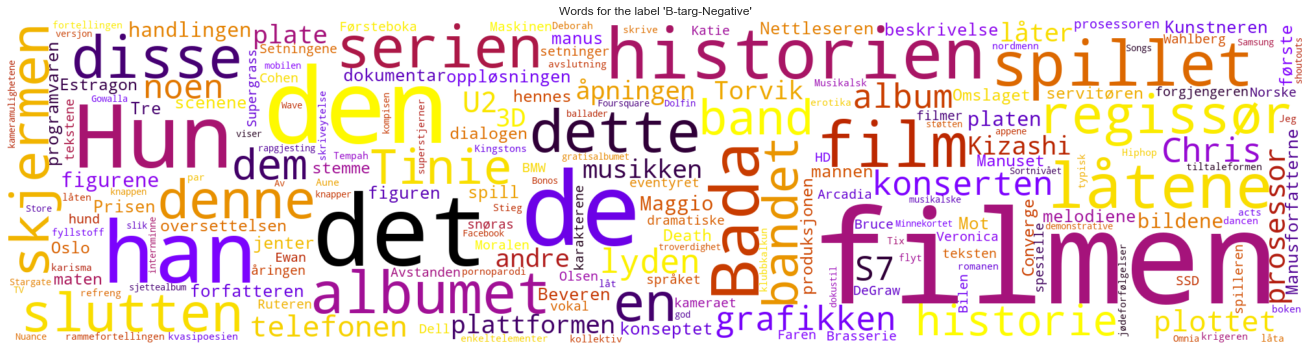

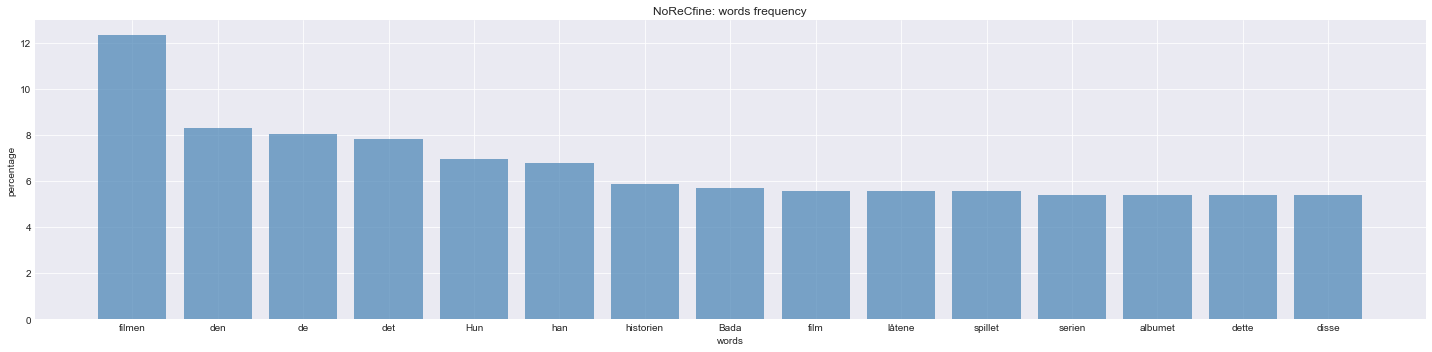

In [42]:
from wordcloud import WordCloud


for i, label in enumerate(LABEL.vocab.itos[1:], 1):
    plt.subplots(figsize=(20, 5))
    # Converting all list of words from train_data to one big string document
    words = ' '.join([word for (k, word) in enumerate(train_text) if train_label[k] == label])
    word_cloud = WordCloud(collocations=False, width=2000, height=500, random_state=21, max_font_size=200, background_color="white", colormap="gnuplot").generate(words)
    # Plot it !
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.title(f"Words for the label '{label}'")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'img/norecfine_{label}.png', dpi=200)
    plt.show()
    
    
    # Frequencies
    all_words_dict = word_cloud.words_
    all_words_freq = softmax(list(all_words_dict.values())[:15]) * 100
    all_words_name = list(all_words_dict.keys())[:15]
    # Plot it !
    plt.subplots(figsize=(20, 5))
    plt.title("NoReCfine: words frequency")
    plt.bar(range(len(all_words_freq)), all_words_freq, align='center', color="steelblue", alpha=0.7)
    plt.xticks(range(len(all_words_freq)), all_words_name)
    plt.ylabel("percentage")
    plt.xlabel("words")

    plt.tight_layout()
    plt.savefig(f'img/norecfine_{label}_frequency.png', dpi=200)
    plt.show()